In [1]:
!pip install kagglehub
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tawsifurrahman_tuberculosis_tb_chest_xray_dataset_path = kagglehub.dataset_download('tawsifurrahman/tuberculosis-tb-chest-xray-dataset')

print('Data source import complete.')


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Pongo\Downloads\tbc-fastapi\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


# **Tuberculosis Classification using DenseNet121** 
---
### **Overview of Tuberculosis (TB)**

**According to [World Health Organization (WHO)](https://www.who.int/health-topics/tuberculosis#tab=tab_1)**
* Tuberculosis is caused by bacteria (Mycobacterium tuberculosis) and it most often affects the lungs. TB is spread through the air when people with lung TB cough, sneeze or spit. A person needs to inhale only a few germs to become infected.
* If we look at chest X-ray of a person with advanced tuberculosis, we will see **infection in lungs** and **the formation of a cavity**.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWfVD5iIMNyJdAYNMayyhK6q3WbfBxynoH_w&usqp=CAU)



Image reference : [radlines.org](https://radlines.org/X-ray_of_the_thorax_in_tuberculosis)


## **Use these links to jump to specific sections of this notebook**
- [1. EDA and splitting data](#1)
    - [Load images and metadata](#1-1)
    - [Split data for train val and test dataset](#1-2)
    - [Display sample images from training dataset](#1-3)
        - [Normal X-ray images](#1-3-1)
        - [Tuberculosis X-ray images](#1-3-2)
- [2. Preprocessing data](#2)
    - [Build a train generator](#2-1)
    - [Build validation and test generators](#2-2)
    - [Display a normalized image in train generator](#2-3)
- [3. Handling class imbalance](#3)
- [4. Transfer learning with DenseNet121](#4)
    - [Model summary](#4-1)
- [5. Model evaluation](#5)
    - [Classification report](#5-1)
    - [Confusion matrix](#5-2)
    - [ROC AUC](#5-3)
- [6. Grad-cam evaluation](#6)
    - [Example of Grad-cam overlay on Tuberculosis](#6-1)


---
<a id='1'></a>
# **EDA and splitting data**

In [2]:
# HAPUS versi bermasalah dan INSTAL ULANG semua paket
!pip uninstall tensorflow keras tensorflow-cpu tensorflow-gpu -y
!pip install --upgrade pip setuptools wheel
!pip install tensorflow==2.15.0 pandas==2.0.3 numpy==1.24.3 matplotlib==3.7.2 seaborn==0.12.2 scikit-learn==1.3.0 opencv-python-headless==4.8.1.78 openpyxl -q

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0


  Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Pongo\Downloads\tbc-fastapi\venv\Scripts\python.exe -m pip install --upgrade pip setuptools wheel

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ========== PERBAIKAN CELL 3 ==========
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

# PERBAIKAN: Ganti semua 'keras' dengan 'tensorflow.keras'
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # PERBAIKAN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model  # PERBAIKAN
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K  # PERBAIKAN
from tensorflow.keras.preprocessing import image  # PERBAIKAN
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import glob
import random
import re
from IPython.display import Image, display
import matplotlib.cm as cm

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Verifikasi
print("✅ TensorFlow version:", tf.__version__)
print("✅ Keras tersedia:", hasattr(tf, 'keras'))
print("✅ Semua library berhasil diimport!")


✅ TensorFlow version: 2.15.0
✅ Keras tersedia: True
✅ Semua library berhasil diimport!


In [4]:
tf.__version__

'2.15.0'

In [5]:
import requests

# 1. Download file dari GitHub (pengganti wget)
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
response = requests.get(url)

# 2. Simpan file ke folder project
with open("helper_functions.py", "wb") as f:
    f.write(response.content)

# 3. Import fungsi (Kode asli kamu)
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix

<a id='1-1'></a>
### **Load images and metadata**

In [6]:

# --- KODE ASLI (HANYA GANTI PATH) ---
# Ganti kata 'tuberculosis' menjadi 'dataset'
df_norm = pd.read_excel('dataset_tb/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('dataset_tb/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [7]:
# Example of metadata
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# ==========================================
# 1. PERSIAPAN DATA (DATA AUGMENTATION)
# ==========================================

# PERBAIKAN DI SINI: Sesuaikan dengan nama folder Anda (dataset_tb)
DATA_DIR = 'dataset_tb/TB_Chest_Radiography_Database'

# Cek dulu apakah folder benar-benar ada (Debugging)
if not os.path.exists(DATA_DIR):
    print(f"❌ ERROR: Folder tidak ditemukan di: {DATA_DIR}")
    print("   Coba cek nama folder di sebelah kiri (Explorer).")
else:
    print(f"✅ Folder ditemukan: {DATA_DIR}")
    print("   Isi folder:", os.listdir(DATA_DIR))

# Setting ukuran gambar (DenseNet suka 224x224)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("\n⏳ Sedang menyiapkan data generator...")

# Membuat variasi data (Augmentasi) agar model tidak "menghapal"
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi pixel ke 0-1
    rotation_range=20,      # Putar gambar acak sampai 20 derajat
    zoom_range=0.15,        # Zoom in/out acak
    width_shift_range=0.1,  # Geser kiri-kanan dikit
    height_shift_range=0.1, # Geser atas-bawah dikit
    horizontal_flip=True,   # Balik gambar (mirror)
    fill_mode='nearest',
    validation_split=0.2    # Ambil 20% data untuk tes (Validation)
)

# Generator Data Latih (Training)
try:
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Generator Data Validasi (Test saat training)
    val_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
except Exception as e:
    print(f"❌ Error Generator: {e}")

# ==========================================
# 2. MEMBANGUN MODEL (DENSENET121)
# ==========================================
print("\n🏗️ Sedang membangun model DenseNet121...")

# Download "Otak" DenseNet bekas latihan ImageNet
base_model = DenseNet121(
    weights='imagenet',
    include_top=False, # Buang kepala aslinya, kita ganti sendiri
    input_shape=(224, 224, 3)
)

# Bekukan base_model agar ilmu aslinya tidak rusak di awal
base_model.trainable = False 

# Tambahkan lapisan akhir (Custom Head)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) 
output = layers.Dense(2, activation='softmax')(x) # 2 Kelas: Normal & TB

model = models.Model(inputs=base_model.input, outputs=output)

# ==========================================
# 3. SETTING PELATIHAN (CALLBACKS & OPTIMIZER)
# ==========================================
# Optimizer dengan learning rate kecil agar teliti
opt = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint('best_model_tb.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("✅ Model Siap! Jalankan cell berikutnya untuk mulai Training (Fit).")

✅ Folder ditemukan: dataset_tb/TB_Chest_Radiography_Database
   Isi folder: ['Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Tuberculosis', 'Tuberculosis.metadata.xlsx']

⏳ Sedang menyiapkan data generator...
Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.

🏗️ Sedang membangun model DenseNet121...


✅ Model Siap! Jalankan cell berikutnya untuk mulai Training (Fit).


In [9]:
# Join both normal and tuberculosis excels
# create Label feature ['Tuberculosis']
df_norm['Tuberculosis'] = 0.0  # atau: float(0)
df_tb['Tuberculosis'] = 1.0 # atau: float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
# Rename column
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [11]:
# Walk through directory
ds = "dataset_tb/TB_Chest_Radiography_Database"
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in 'dataset_tb/TB_Chest_Radiography_Database'.
There are 0 directories and 3500 images in 'dataset_tb/TB_Chest_Radiography_Database\Normal'.
There are 0 directories and 700 images in 'dataset_tb/TB_Chest_Radiography_Database\Tuberculosis'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [12]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
    train_dir = os.path.join(root_path,'training')
    val_dir = os.path.join(root_path, 'validation')
    test_dir = os.path.join(root_path,'testing')
    
    # Tambahkan exist_ok=True di setiap baris
    os.makedirs(train_dir + '/Normal', exist_ok=True)
    os.makedirs(train_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(val_dir + '/Normal', exist_ok=True)
    os.makedirs(val_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(test_dir + '/Normal', exist_ok=True)
    os.makedirs(test_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(root_path + '/Images', exist_ok=True)
    
    print("✅ Folder structure created successfully!")

# Panggil dengan path yang benar
create_img_train_val_test_dirs('./')

✅ Folder structure created successfully!


In [13]:
# Map train validation test directories

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

<a id='1-2'></a>
### **Split data for train val and test dataset**
#### Partition as {train : 80, Val : 10, Test : 10}
#### Equally split for both Normal and Tuberculosis

In [14]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')
    
  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

    
split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [15]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [16]:
len(os.listdir(IMAGE_DIR))

4200

In [17]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [18]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [19]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'].str.replace(r'\.png$', '', regex=True) + '.png'
val_df['Image'] = val_df['Image'].str.replace(r'\.png$', '', regex=True) + '.png'
test_df['Image'] = test_df['Image'].str.replace(r'\.png$', '', regex=True) + '.png'

In [20]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


<a id='1-3'></a>
### **Display sample images from training dataset**

In [21]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [22]:
train_norm[:5]

['./training\\Normal\\Normal-10.png',
 './training\\Normal\\Normal-100.png',
 './training\\Normal\\Normal-1000.png',
 './training\\Normal\\Normal-1002.png',
 './training\\Normal\\Normal-1003.png']

<a id='1-3-1'></a>
### **Normal X-ray images**

Normal


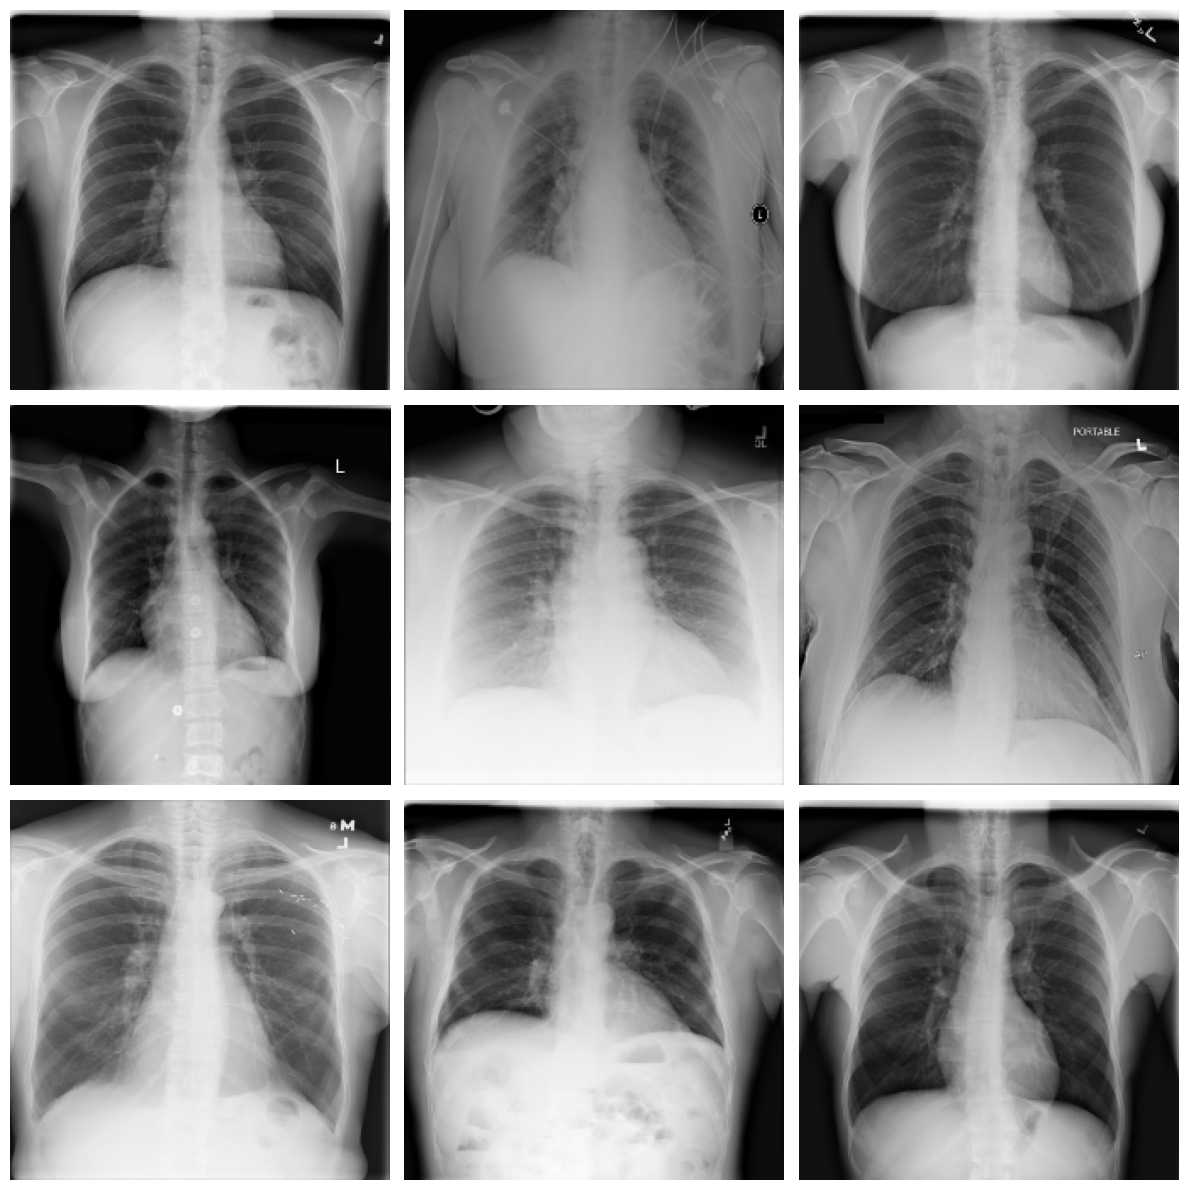

In [23]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

<a id='1-3-2'></a>
### **Tuberculosis X-ray images**

Tuberculosis


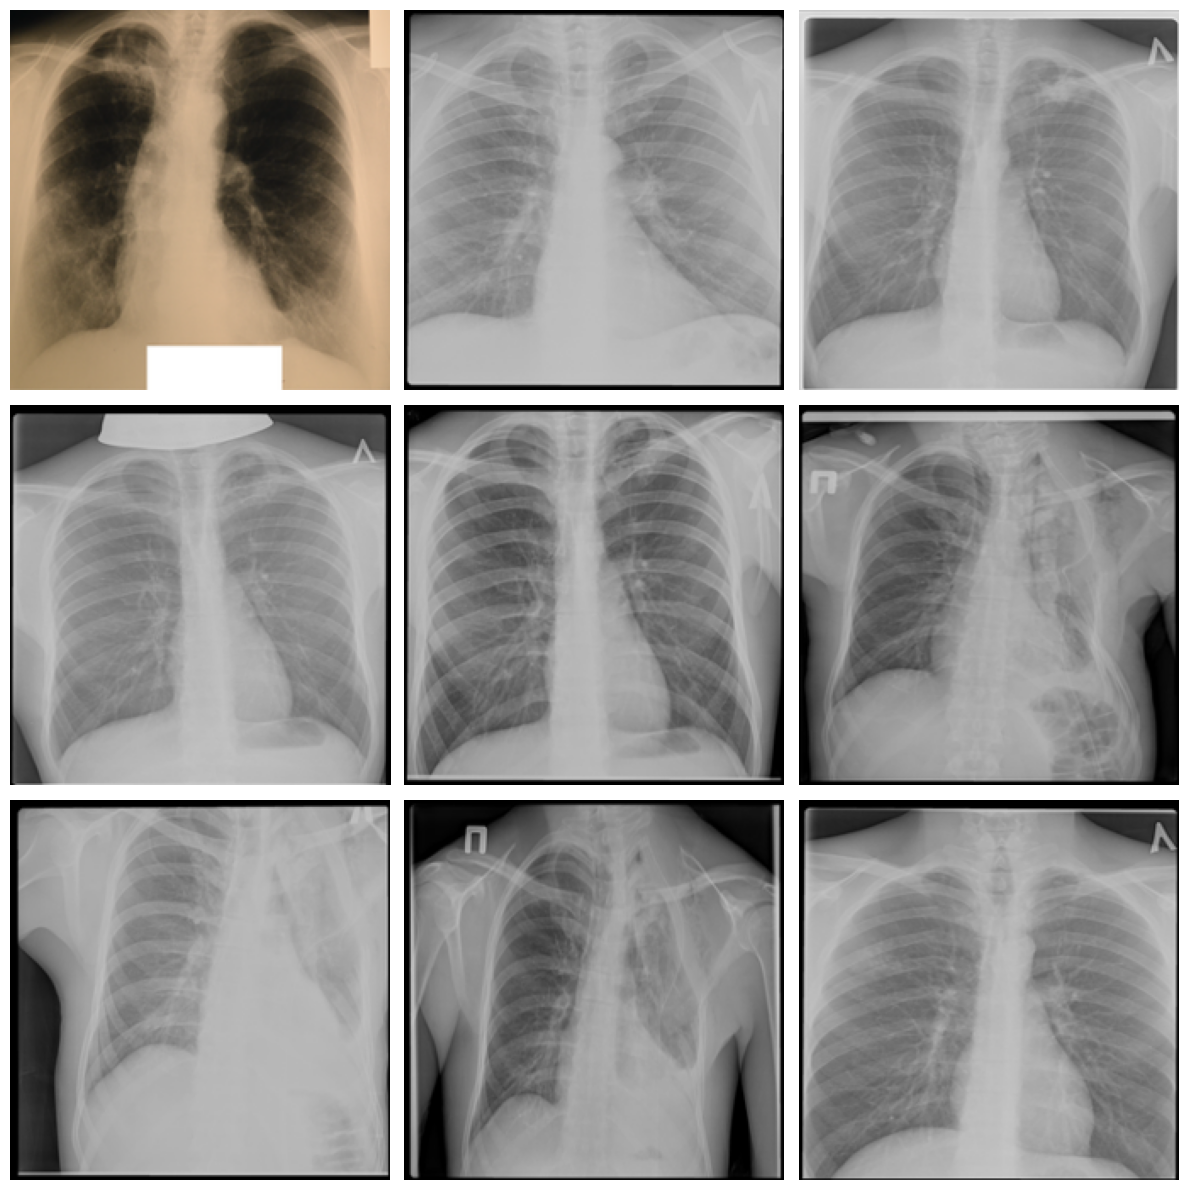

In [24]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

<a id='2'></a>
# **Preprocessing data**

<a id='2-1'></a>
## **Build a train generator**
### **few things to note:** 
1. We **normalize** the mean and standard deviation of **each data**
2. We **shuffle** the input after each epoch.
3. We set the image size to be **320px by 320px**
4. We apply some **aumentations (Rotation, Zoom, Width shift and Height shift)** based on possition deviation which could possibly be slightly changed when radiographers x-ray patients
5. The generator converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels. (The pre-trained model requires three-channel inputs)

In [25]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.
    
    print("getting train generator...") 
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
   
    return train_generator

<a id='2-2'></a>
## **Build validation and test generators**
### **few things to note:**
1. We normalize validation data and incoming test data using the **statistics computed from the training set**
2. For reduce time consuming, we'll take a random sample of the dataset and calculate the sample mean and sample standard deviation. (Ideally, we should compute our sample mean and standard deviation using the entire training set)

In [26]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    # This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return val_generator, test_generator

In [27]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3360 validated image filenames.
getting val and test generators...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


In [28]:
# CEK: Apa isi folder Images?
import os

print("🔍 Checking IMAGE_DIR contents:")
IMAGE_DIR = "./Images"  # Pastikan ini sama dengan di cell 12

print(f"IMAGE_DIR path: {os.path.abspath(IMAGE_DIR)}")
print(f"Folder exists: {os.path.exists(IMAGE_DIR)}")

if os.path.exists(IMAGE_DIR):
    files = os.listdir(IMAGE_DIR)
    print(f"\n📁 Files in IMAGE_DIR ({len(files)} total):")
    
    # Tampilkan beberapa file pertama
    for i, file in enumerate(files[:10]):
        print(f"  {i+1}. {file}")
    
    if len(files) > 10:
        print(f"  ... and {len(files)-10} more")
    
    # Cek file extension
    print("\n📄 File extensions:")
    extensions = {}
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        extensions[ext] = extensions.get(ext, 0) + 1
    
    for ext, count in extensions.items():
        print(f"  {ext}: {count} files")
    
    # Cek apakah ada file dari train_df
    print("\n🔍 Checking if train_df images exist in IMAGE_DIR:")
    sample_images = train_df['Image'].head(5).tolist()
    for img_name in sample_images:
        img_path = os.path.join(IMAGE_DIR, img_name)
        exists = os.path.exists(img_path)
        print(f"  {img_name}: {'✅' if exists else '❌'} {img_path}")
else:
    print("❌ IMAGE_DIR tidak ditemukan!")

🔍 Checking IMAGE_DIR contents:
IMAGE_DIR path: c:\Users\Pongo\Downloads\tbc-fastapi\model\Images
Folder exists: True

📁 Files in IMAGE_DIR (4200 total):
  1. Normal-1.png
  2. Normal-10.png
  3. Normal-100.png
  4. Normal-1000.png
  5. Normal-1001.png
  6. Normal-1002.png
  7. Normal-1003.png
  8. Normal-1004.png
  9. Normal-1005.png
  10. Normal-1006.png
  ... and 4190 more

📄 File extensions:
  .png: 4200 files

🔍 Checking if train_df images exist in IMAGE_DIR:
  Normal-1351.png: ✅ ./Images\Normal-1351.png
  Normal-512.png: ✅ ./Images\Normal-512.png
  Normal-2790.png: ✅ ./Images\Normal-2790.png
  Normal-1189.png: ✅ ./Images\Normal-1189.png
  Normal-2444.png: ✅ ./Images\Normal-2444.png


<a id='2-3'></a>
### **Display a normalized image in train generator**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


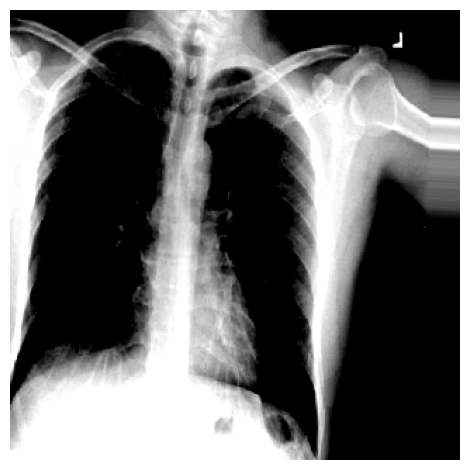

Image shape (320, 320, 3)


In [29]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

<a id='3'></a>
# **Handling class imbalance** 
### Fixed by Sample Weighting in Loss Function (weighting the contributions of positive and negative losses to be equal)
#### More information cae be read [here](https://www.kaggle.com/code/sanphats/microcalcification-weighting-loss-dnn)



In [30]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [31]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

create positive/negative contributors
$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$
$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

In [32]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Final weight loss
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [33]:
# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

<a id='4'></a>
# **Transfer learning with DenseNet121**

In [34]:
## create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=["accuracy","AUC"])

In [35]:
# callbacks 

checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
#RLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 2, min_lr =0.001)
#ES = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 2)


In [36]:
# fit model
history = model.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps= 30,  
                              epochs = 3,
                              callbacks = [MC])

Epoch 1/3


100/100 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.8850 - auc: 0.9336
Epoch 1: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 355s 3s/step - loss: 0.1016 - accuracy: 0.8850 - auc: 0.9336 - val_loss: 2.1491 - val_accuracy: 0.8333 - val_auc: 0.5000
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.8888 - auc: 0.9400
Epoch 2: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 525s 5s/step - loss: 0.0949 - accuracy: 0.8888 - auc: 0.9400 - val_loss: 2.0800 - val_accuracy: 0.8333 - val_auc: 0.5125
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.8988 - auc: 0.9445
Epoch 3: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 402s 4s/step - loss: 0.0833 - accuracy: 0.8988 - auc: 0.9445 - val_loss: 0.4668 - val_accuracy: 0.9000 - val_auc: 0.8342


In [37]:
# load weights
model = Model(inputs=base_model.input, outputs = output)
model.load_weights(checkpoint_path)

<a id='4-1'></a>
### **Model summary**

In [38]:
#model.summary()

<a id='5'></a>
# **Model evaluation**

In [39]:
#### Information and codes can be found here [AI in Medical diagnosis course](https://www.coursera.org/learn/ai-for-medical-diagnosis)
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


random.seed(a=None, version=2)
set_verbosity(INFO)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

<a id='5-1'></a>
## **Classification report**

In [40]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

In [41]:
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       350
         1.0       0.74      0.66      0.70        70

    accuracy                           0.90       420
   macro avg       0.84      0.81      0.82       420
weighted avg       0.90      0.90      0.90       420

Accuracy of the Model: 90.47619047619048 %


In [42]:
# save predictions to csv file

y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

<a id='5-2'></a>
## **Confusion matrix**

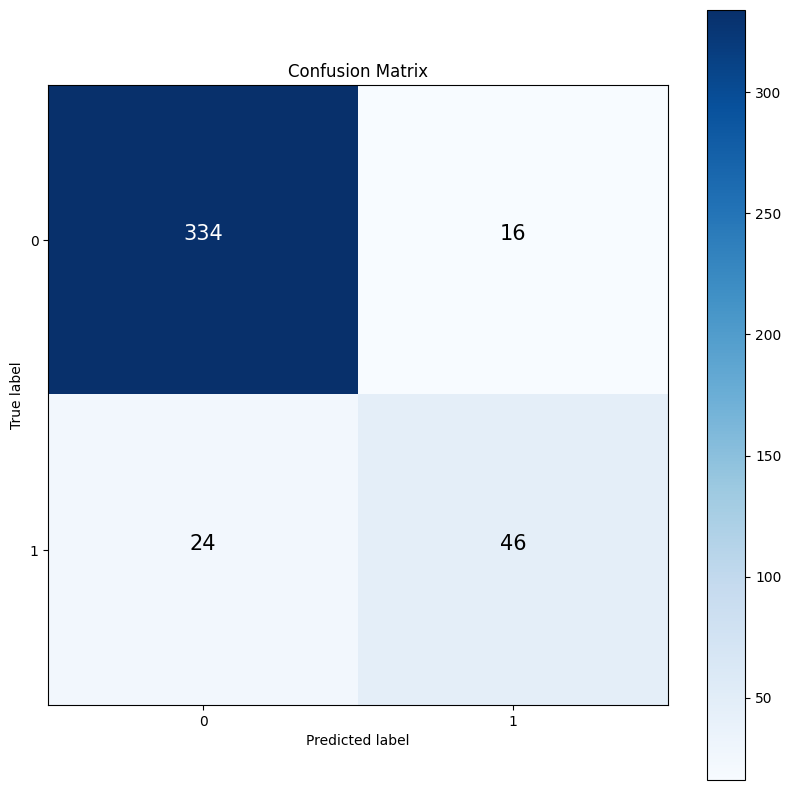

In [43]:
make_confusion_matrix(y_test, y_pred)

<a id='5-3'></a>
## **ROC AUC**

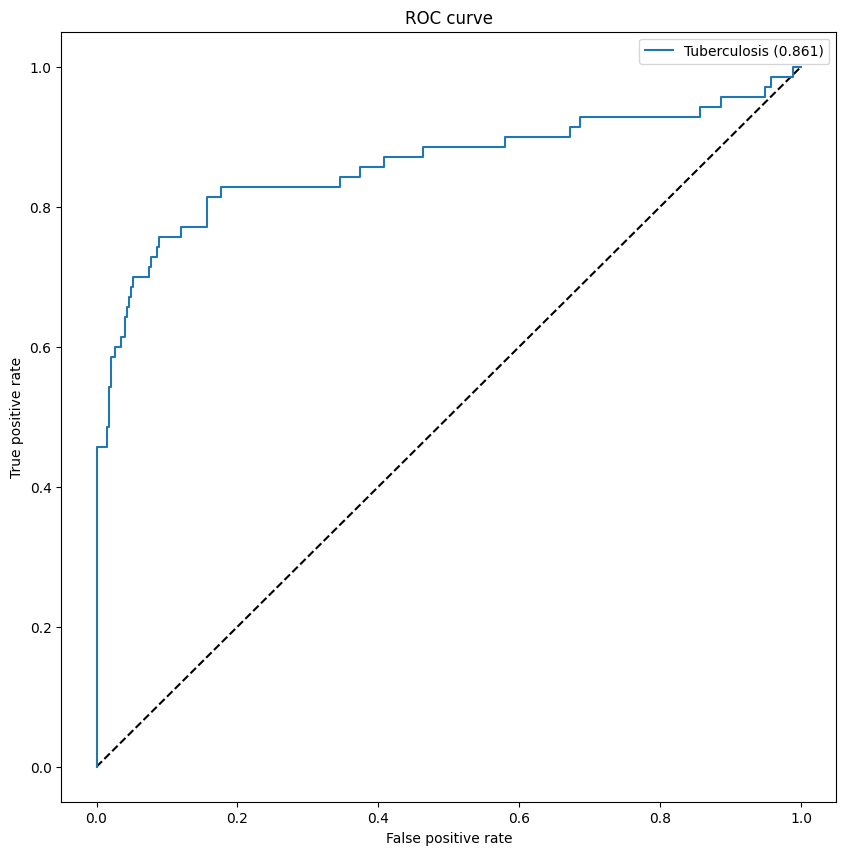

In [44]:
labels = ['Tuberculosis']
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

<a id='6'></a>
# **Grad-cam evaluation**

#### Information of Gradient-weighted Class Activation Mapping (Grad-CAM) can be found here [Cornell University](https://arxiv.org/abs/1610.02391)
#### Codes are inspired by [stackoverflow](https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network)

In [45]:
# Normalization using batch statistics
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(50)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
    return x


In [46]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [47]:
# Sample 50 images for Batch normalization
imgs_path = []
for fn in test_df['Image'][:50]:
    full_path = IMAGE_DIR + '/' + fn
    imgs_path.append(full_path)

In [48]:
# Normalize with mean and std of batchs
test = [load_image(i, IMAGE_DIR, test_df ) for i in imgs_path]

In [49]:
# convert to numpy array
test = np.array(test)
print(test.shape)

(50, 320, 320, 3)


In [50]:
import numpy as np

# 1. Lakukan Prediksi
print("Sedang memprediksi...")
preds = model.predict(test)

# 2. Ambil probabilitas Tuberculosis
# Jika model pakai 2 output (Softmax), kolom 0=Normal, 1=TB. Kita ambil kolom 1.
# Jika model pakai 1 output (Sigmoid), data sudah langsung probabilitas TB.
if preds.shape[1] > 1:
    tb_probs = preds[:, 1] # Ambil kolom kedua (Tuberculosis)
else:
    tb_probs = preds.flatten()

# 3. Cari gambar dengan skor Tuberculosis TERTINGGI (Max Score)
# Ini menjamin kita pasti dapat 1 gambar, meskipun skornya rendah (misal cuma 0.4)
n = np.argmax(tb_probs)
max_score = tb_probs[n]

print(f"✅ Gambar terpilih: Index ke-{n}")
print(f"📊 Skor Probabilitas TB: {max_score:.4f} ({max_score*100:.2f}%)")

# Logika tambahan untuk info
if max_score < 0.5:
    print("⚠️ Peringatan: Model sebenarnya memprediksi ini Normal (skor < 0.5).")
    print("Kita memaksakan gambar ini hanya untuk keperluan visualisasi Grad-CAM.")
else:
    print("🎯 Model yakin ini adalah Tuberculosis!")

Sedang memprediksi...
2/2 [==============================] - 4s 969ms/step
✅ Gambar terpilih: Index ke-15
📊 Skor Probabilitas TB: 0.9973 (99.73%)
🎯 Model yakin ini adalah Tuberculosis!


In [51]:
# Now we know which images were predicted as Tuberculosis from preds_
# create img_test which is predicted Tuberculosis
img_test = np.expand_dims(test[n], axis = 0)
preds = model.predict(img_test) 
i = np.where(preds > 0.5,1,0)

# Verify if prediction == 1
i.flatten()

1/1 [==============================] - 0s 143ms/step


array([1])

In [52]:
# Create the original image path of img_test

img_path = imgs_path[n]

In [53]:
icam = GradCAM(model, i, 'conv5_block16_1_conv') 
heatmap = icam.compute_heatmap(img_test)
heatmap = cv2.resize(heatmap, (320, 320))

image = cv2.imread(img_path)
image = cv2.resize(image, (320, 320))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(320, 320) (320, 320, 3)


<a id='6-1'></a>
## **Example of Grad-cam overlay on Tuberculosis**

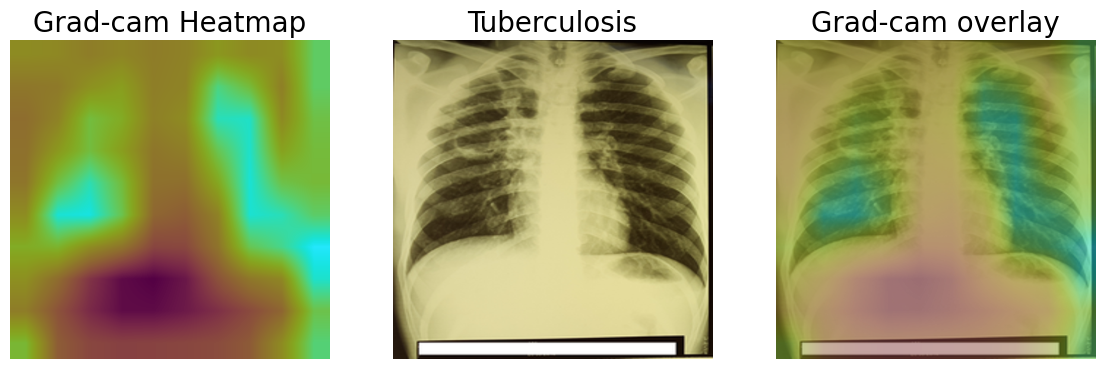

In [54]:
fig, ax = plt.subplots(1, 3, figsize = (14,14))

ax[0].imshow(heatmap)
ax[0].axis('Off')
ax[0].set_title('Grad-cam Heatmap', fontsize = 20)
ax[1].imshow(image)
ax[1].axis('Off')
ax[1].set_title('Tuberculosis', fontsize = 20)
ax[2].imshow(output)
ax[2].axis('Off')
ax[2].set_title('Grad-cam overlay', fontsize = 20)
fig.show()

In [ ]:
# Simpan model ke format .keras
model.save('densenet_model.keras')
print("Model berhasil disimpan!")

---
#### Thank you so much for reading :)
#### Please feel free to copy and edit this notebook
SANPHAT S.